### Light curve calculation
binned in runs, or in nights

In [1]:
import numpy as np
import pickle
import mysql.connector
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.offsetbox import AnchoredText

In [2]:
def query(command):
    conn = mysql.connector.connect(user='xxxx',password='xxxxxx',host='xxxxxx',database='xxxxxx',port='xxxxxx')
    cursor = conn.cursor()    
    result = pd.read_sql_query(command, conn)
    conn.close()
    return result

In [3]:
cmd = '''
SELECT
   Images.*,
   Position.X,
   Position.Y
FROM
   Images
LEFT JOIN Position USING (FileId, EvtNumber)
LEFT JOIN RunInfo  USING (FileId)
WHERE
   fSourceKey=7
AND
   fRunTypeKey=1
AND
   FileId BETWEEN 160601000 AND 160615000
AND
   fR750Cor>0.9*fR750Ref
AND
   NumUsedPixels>5.5
AND
   NumIslands<3.5
AND
   Leakage1<0.1
AND
   Width*Length*PI() < LOG10(Size)*898-1535
'''
data = query(cmd)

In [4]:
# useful values
mm2deg = 0.0117193246260285378
# Create bins for the histogram
bins_number = 30
bins = np.linspace(0,0.3,bins_number+1)
ratio_on_off = 1/5 # ratio between on and off regions

In [5]:
# transforming the column names into arrays with the name of the column and with its values
for par in list(data.columns):
    vars()[par] = data[f'{par}'].values

In [6]:
data.keys()

Index(['FileId', 'EvtNumber', 'Mjd', 'MilliSec', 'NanoSec', 'Length', 'Width',
       'Delta', 'Size', 'MeanX', 'MeanY', 'SinDelta', 'CosDelta', 'Asym',
       'M3Long', 'M3Trans', 'SlopeLong', 'SlopeTrans', 'TimeSpread',
       'TimeSpreadWeighted', 'SlopeSpread', 'SlopeSpreadWeighted',
       'NumIslands', 'SizeSubIslands', 'SizeMainIsland', 'Leakage1',
       'Leakage2', 'Conc', 'Conc1', 'ConcCOG', 'ConcCore', 'UsedArea',
       'CoreArea', 'NumUsedPixels', 'NumCorePixels', 'X', 'Y'],
      dtype='object')

In [7]:
data

,FileId,EvtNumber,Mjd,MilliSec,NanoSec,Length,Width,Delta,Size,MeanX,...,Conc,Conc1,ConcCOG,ConcCore,UsedArea,CoreArea,NumUsedPixels,NumCorePixels,X,Y
0,160601129,20,57541,10306458,2000,19.7443,9.29764,1.251720,530.102,110.74200,...,0.168128,0.086776,0.185578,0.435058,3595.30,3595.30,46,46,-43.63780,-26.7584
1,160601129,121,57541,10308336,726000,21.6628,11.03890,-0.810581,558.031,19.28490,...,0.160833,0.094753,0.222658,0.500644,4298.73,4298.73,55,55,-43.63300,-26.7663
2,160601129,132,57541,10308545,932000,20.2568,4.94009,-0.584301,148.094,-6.05577,...,0.218401,0.111416,0.257227,0.570796,1641.33,1641.33,21,21,-43.63240,-26.7672
3,160601129,164,57541,10309002,249000,29.4977,12.71310,-1.313240,1329.350,-106.85100,...,0.104563,0.056795,0.118573,0.526998,7659.55,7659.55,98,98,-43.63120,-26.7691
4,160601129,243,57541,10310530,369000,31.1555,13.68010,0.773929,2748.170,-100.39500,...,0.138274,0.083146,0.098429,0.583592,11254.90,11254.90,144,144,-43.62730,-26.7756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174282,160614174,1596,57554,18323203,966000,31.2927,6.96963,-0.023871,305.207,69.24360,...,0.131878,0.070649,0.148772,0.460292,2891.87,2891.87,37,37,-6.37507,50.7920
174283,160614174,1609,57554,18323674,696000,27.0270,10.04080,-1.056230,832.324,19.43150,...,0.113537,0.059772,0.155739,0.507352,5158.48,5158.48,66,66,-6.37745,50.7917
174284,160614174,1614,57554,18323790,75000,28.0474,16.85260,0.296838,3337.040,-106.24300,...,0.077763,0.040155,0.106232,0.484018,9613.53,9613.53,123,123,-6.37804,50.7916
174285,160614174,1632,57554,18324524,753000,17.7440,9.96415,0.250701,270.020,-125.27200,...,0.161794,0.086799,0.167002,0.425027,2657.40,2657.40,34,34,-6.38174,50.7911


In [8]:
# First calculate all cuts to speedup the analysis
area =  np.pi*Width*Length
    
non = np.zeros((len(FileId)))
noff = np.zeros((5, len(FileId)))

# Loop over all wobble positions in the camera
for k, angle in enumerate(range(0,360,60)):

    # ----------- Source dependent parameter calculation ----------
    cr = np.cos(np.deg2rad(angle))
    sr = np.sin(np.deg2rad(angle))

    # the position of the source in each wobble position
    px = cr*X-sr*Y 
    py = cr*Y+sr*X  

    # distance of the center of gravity to the source center in each wobble position
    dx = MeanX-px*1.02  
    dy = MeanY-py*1.02

    norm = np.sqrt(dx*dx+dy*dy)
    dist = norm*mm2deg

    # these are unitary vectors in the ellipse frame, lx and ly are alligned with the short and long ellipse axes
    lx = np.minimum(np.maximum((CosDelta*dy-SinDelta*dx)/norm,(-1*np.ones(area.shape))),np.ones(area.shape))
    ly = np.minimum(np.maximum((CosDelta*dx+SinDelta*dy)/norm,(-1*np.ones(area.shape))),np.ones(area.shape))

    alpha = np.arcsin(lx)
    sgn = np.sign(ly)

    # ------------------------ Application ---------------------
    # both help to say from which of the two solutions for disp i should use
    m3l = M3Long*sgn*mm2deg
    slope = SlopeLong*sgn/mm2deg

    # -------------------------- Analysis ----------------------
    xi = 1.39252+0.154247*slope+1.67972*(1-1/(1+4.86232*Leakage1))

    sign1 = m3l+0.07
    sign2 = (dist-0.5)*7.2-slope

    xi_final = xi.copy()
    for i, is_negative in enumerate((sign1<0) | (sign2<0)):
        if is_negative:
            xi_final[i] = -xi_final[i]

    disp = xi_final*(1-Width/Length)

    # this is the formula c^2 = a^2 + b^2 - 2ab*cos alpha , cos² alpha + sin² = 1
    # in this case dist = distance of the ellipse center to the pointing 
    thetasq = disp*disp+dist*dist-2*disp*dist*np.sqrt(1-lx*lx)
    
    if angle == 0:
        non = thetasq
    else:
        noff[k-1] = thetasq

In [9]:
dates_array = (FileId / 1000).astype(int)
dates_unique = np.unique(dates_array)

In [10]:
def plotting(non_binning, noff_binning, title):
    plt.hist(bins[:-1], bins=bins,histtype='step', weights=non_binning, label='ON')
    plt.hist(bins[:-1], bins=bins,histtype='step', weights=ratio_on_off*noff_binning, label='OFF')
    plt.title(f'{title}')
    plt.grid(alpha=0.25)
    plt.xlabel(r'$\theta^{2} [deg^{2}]$')
    plt.ylabel('Events counts')
    plt.legend()
    plt.show()
    return

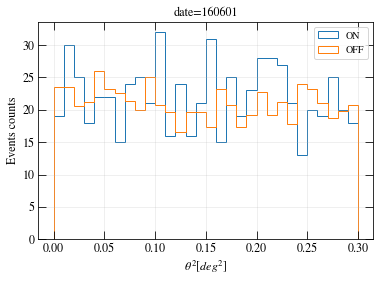

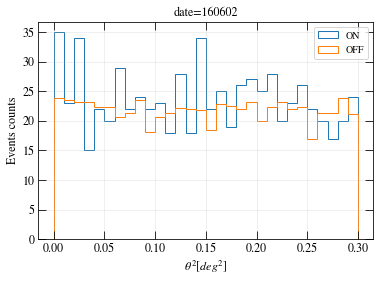

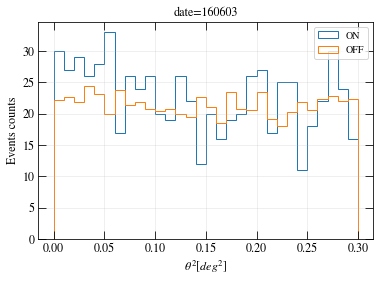

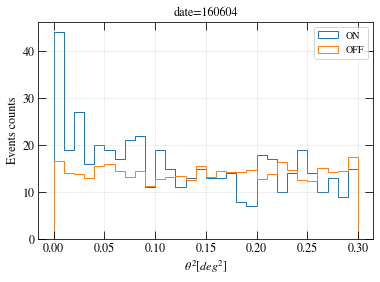

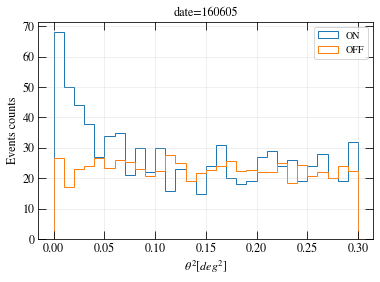

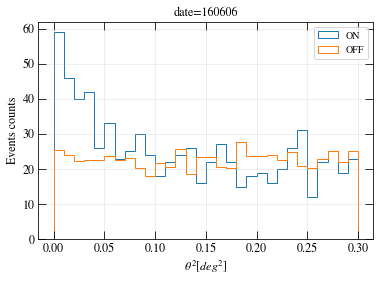

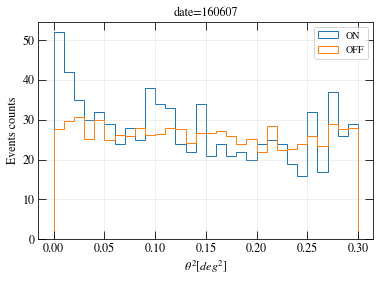

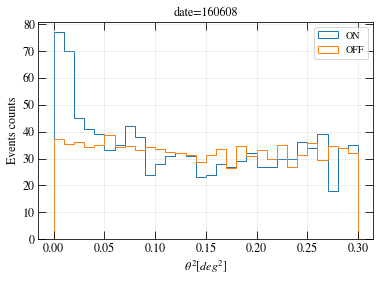

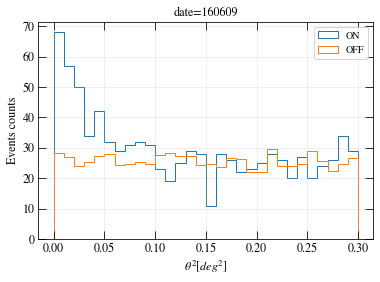

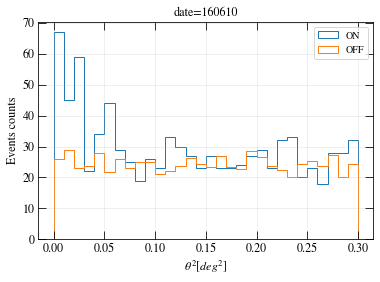

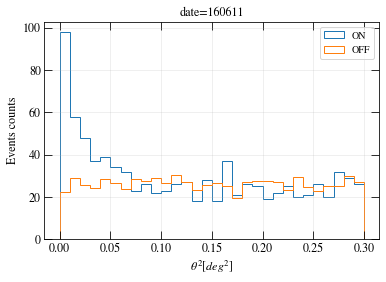

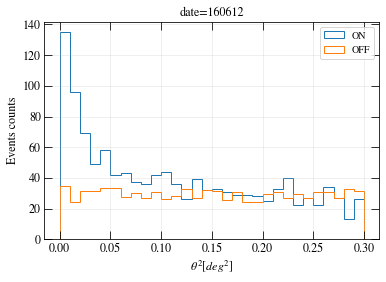

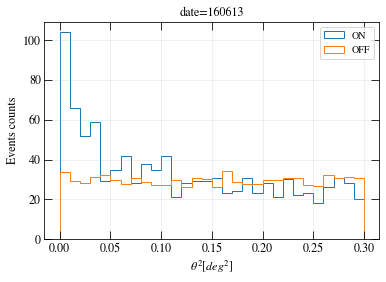

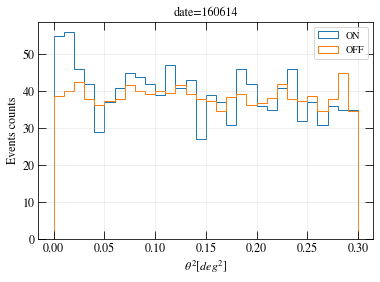

In [11]:
for date in dates_unique:
    mask = (dates_array == date)
    noff_hist = np.histogram(noff[:,mask].ravel(), bins=bins)
    non_hist = np.histogram(non[mask], bins=bins)
    plotting(non_hist[0], noff_hist[0], f'date={date}')

In [12]:
# let's say i apply the same theta2 cut for all the days
cut_theta2 = 0.04
mask_theta2 = bins < cut_theta2

In [13]:
excess_total = np.zeros(len(dates_unique))

for i, date in enumerate(dates_unique):
    mask = (dates_array == date)
    noff_hist = np.histogram(noff[:,mask].ravel(), bins=bins)
    non_hist = np.histogram(non[mask], bins=bins)
    
    # summing the counts that survived the cut in theta2
    N_on = np.sum(non_hist[0][mask_theta2[:-1]])
    N_off = np.sum(ratio_on_off*noff_hist[0][mask_theta2[:-1]])
    
    # excess
    excess_total[i] = N_on - N_off

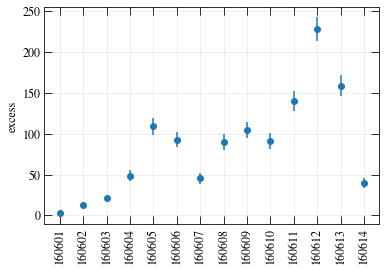

In [14]:
plt.errorbar(dates_unique.astype(str), excess_total, yerr=np.sqrt(excess_total), ls='none', marker='o')
plt.xticks(dates_unique.astype(str), dates_unique.astype(str), rotation='vertical');
plt.ylabel('excess')
plt.grid(alpha=0.25)

The plot above shows the total excess of the night. <br>
It can happen that one night has more runs than others. <br>
For a fair comparison, we can plot the excess while considering how many hours of observation were taken into account.

In [15]:
# what are the runs we have in this data?
runs_unique = np.unique(FileId, return_index=True, return_inverse=True, return_counts=True)

In [16]:
runs_pernight = np.unique((runs_unique[0]/1000).astype(int), return_index=True, return_inverse=True, return_counts=True)

In [17]:
# it shows me how many nights we have
runs_pernight[0]

array([160601, 160602, 160603, 160604, 160605, 160606, 160607, 160608,
       160609, 160610, 160611, 160612, 160613, 160614])

In [18]:
# it shows me how many runs per night we have
runs_pernight[3]

array([37, 40, 35, 29, 35, 42, 38, 42, 39, 37, 39, 44, 44, 46])

In [24]:
# Each run has 5 mins duration, but i want it in hours
excess_night_perhour = excess_total/(runs_pernight[3]*5/60)
excess_night_perhour_err = np.sqrt(excess_total)/(runs_pernight[3]*5/60)

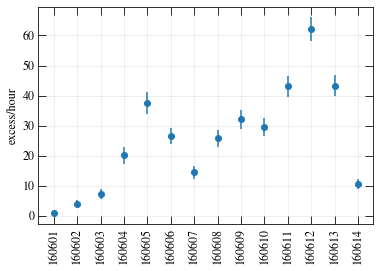

In [25]:
# plt.errorbar(dates_unique.astype(str), excess_total, yerr=np.sqrt(excess_total), ls='none', marker='o')
plt.errorbar(dates_unique.astype(str), excess_night_perhour, yerr=excess_night_perhour_err, ls='none', marker='o')
plt.xticks(dates_unique.astype(str), dates_unique.astype(str), rotation='vertical');
plt.ylabel('excess/hour')
plt.grid(alpha=0.25)

Converting the dates into MJD dates

In [31]:
mjd_unique = np.unique(Mjd)
# calculate the bin size in days
dt = np.diff(mjd_unique)
# assume all bins are the same size
mjd_min = mjd_unique - dt[0] / 2.
mjd_max = mjd_unique + dt[0] / 2.

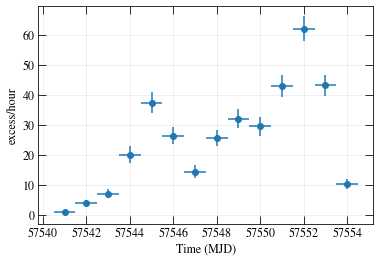

In [32]:
plt.errorbar(mjd_unique, excess_night_perhour,
             yerr=excess_night_perhour_err,
             xerr=[mjd_unique - mjd_min, mjd_max - mjd_unique],
             ls='none', marker='o')
plt.ylabel('excess/hour')
plt.xlabel("Time (MJD)")
plt.grid(alpha=0.25)

Save the light curve to a numpy file

In [35]:
np.savez("light_curve",
        excess_per_hour=excess_night_perhour,
        excess_per_hour_err=excess_night_perhour_err,
        mjd=mjd_unique,
        mjd_min=mjd_min,
        mjd_max=mjd_max
       )

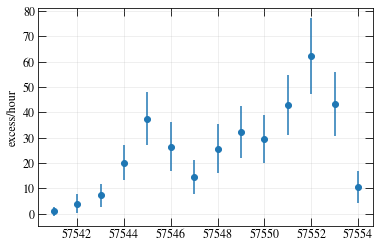

In [22]:
# plt.errorbar(dates_unique.astype(str), excess_total, yerr=np.sqrt(excess_total), ls='none', marker='o')
plt.errorbar(mjd_unique, excess_night_perhour, yerr=np.sqrt(excess_total), ls='none', marker='o')
plt.ylabel('excess/hour')
plt.grid(alpha=0.25)

Now we can to take a closer look into the 12th night, so we do a finer binning, precisely runwise. 

In [23]:
selected_date = 160612
runs_in_selected_date = ((runs_unique[0]/1000).astype(int) == selected_date)
runs_in_selected_date = runs_unique[0][runs_in_selected_date]

In [24]:
excess_total = np.zeros(len(runs_in_selected_date))
for i, run in enumerate(runs_in_selected_date):
    mask = FileId == run
    noff_hist = np.histogram(noff[:,mask].ravel(), bins=bins)
    non_hist = np.histogram(non[mask], bins=bins)
    
    # summing the counts that survived the cut in theta2
    N_on = np.sum(non_hist[0][mask_theta2[:-1]])
    N_off = np.sum(ratio_on_off*noff_hist[0][mask_theta2[:-1]])
    
    # excess
    excess_total[i] = N_on-N_off

/Users/manuelmeyer/anaconda3/envs/gammapy-0.16/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Excess plot per run')

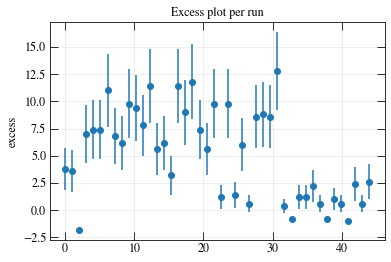

In [25]:
plt.errorbar(np.linspace(0,len(runs_in_selected_date),len(runs_in_selected_date)), excess_total, yerr=np.sqrt(excess_total), ls='none', marker='o')
plt.ylabel('excess')
plt.grid(alpha=0.25)
plt.title('Excess plot per run')

With too fine binning it is hard to see something or understand what is happening, therefore a bigger bin is necessary to compensate the lack of statistics

In [26]:
# I want to merge every 4 runs, meaning 20 min

group_n_runs = 4
excess_grouped_runs = np.sum(excess_total.reshape(-1,group_n_runs), axis=1)

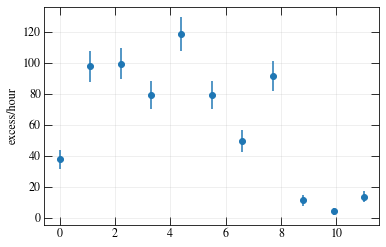

In [27]:
#this is a conversion from runs to excess counts per hour

factor = 60/(5*group_n_runs) #60 min/group run min

plt.errorbar(np.linspace(0,len(excess_grouped_runs),len(excess_grouped_runs)), factor*excess_grouped_runs, yerr=np.sqrt(factor*excess_grouped_runs), ls='none', marker='o')
plt.ylabel('excess/hour')
plt.grid(alpha=0.25)

## better to change this x-label to mjd